# 2.3 Layer-wise Relevance Propagation Part 2.

## Tensorflow Walkthrough

### 1. Import Dependencies

I made a custom `LRP` class for Layer-wise Relevance Propagation. If you are interested in the details, check out `models_3_1.py` in the models directory.

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_2_3 import MNIST_NN, MNIST_DNN, LRP
from utils import pixel_range

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
images = mnist.train.images
labels = mnist.train.labels

logdir = './tf_logs/2_3_LRP/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_DNN('DNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('LRP', X)
    
    for activation in activations:
        tf.add_to_collection('LRP', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.222209546 accuracy = 0.932272729
Epoch: 0002 cost = 0.094443713 accuracy = 0.971490917
Epoch: 0003 cost = 0.066750223 accuracy = 0.979527283
Epoch: 0004 cost = 0.050566955 accuracy = 0.984109102
Epoch: 0005 cost = 0.039164860 accuracy = 0.988254555
Epoch: 0006 cost = 0.035111508 accuracy = 0.989545463
Epoch: 0007 cost = 0.033497745 accuracy = 0.989563645
Epoch: 0008 cost = 0.026709843 accuracy = 0.991909098
Epoch: 0009 cost = 0.023360011 accuracy = 0.992781824
Epoch: 0010 cost = 0.021341650 accuracy = 0.993490915
Epoch: 0011 cost = 0.019153027 accuracy = 0.994236369
Epoch: 0012 cost = 0.017887942 accuracy = 0.995036368
Epoch: 0013 cost = 0.019383043 accuracy = 0.994763641
Epoch: 0014 cost = 0.015831556 accuracy = 0.995163641
Epoch: 0015 cost = 0.017971029 accuracy = 0.994836368
Accuracy: 0.9793


### 4. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary weights and biases for LRP using the `tf.get_collection()` function.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*kernel.*')
biases = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*bias.*')
activations = tf.get_collection('LRP')
X = activations[0]

INFO:tensorflow:Restoring parameters from ./tf_logs/3_1_LRP/model


### 5. Attaching Subgraph for Calculating Relevance Scores

In [5]:
conv_ksize = [1, 3, 3, 1]
pool_ksize = [1, 2, 2, 1]
conv_strides = [1, 1, 1, 1]
pool_strides = [1, 2, 2, 1]

weights.reverse()
biases.reverse()
activations.reverse()

# LRP-alpha1-beta0
lrp10 = LRP(1, activations, weights, biases, conv_ksize, pool_ksize, conv_strides, pool_strides, 'LRP10')

# LRP-alpha2-beta1
lrp21 = LRP(2, activations, weights, biases, conv_ksize, pool_ksize, conv_strides, pool_strides, 'LRP21')

Rs10 = [lrp10(i) for i in range(10)]
Rs21 = [lrp21(i) for i in range(10)]

### 6. Calculating Relevance Scores $R(x_i)$

In [6]:
sample_imgs = []
for i in range(10):
    sample_imgs.append(images[np.argmax(labels, axis=1) == i][3])

imgs10 = []
imgs21 = []
for i in range(10):
    imgs10.append(sess.run(Rs10[i], feed_dict={X: sample_imgs[i][None,:]}))
    imgs21.append(sess.run(Rs21[i], feed_dict={X: sample_imgs[i][None,:]}))

sess.close()

### 7. Displaying Images for LRP-$\alpha_1 \beta_0$

The relevance scores are visualized as heat maps. You can see which features/data points influenced the DNN most its decision making.

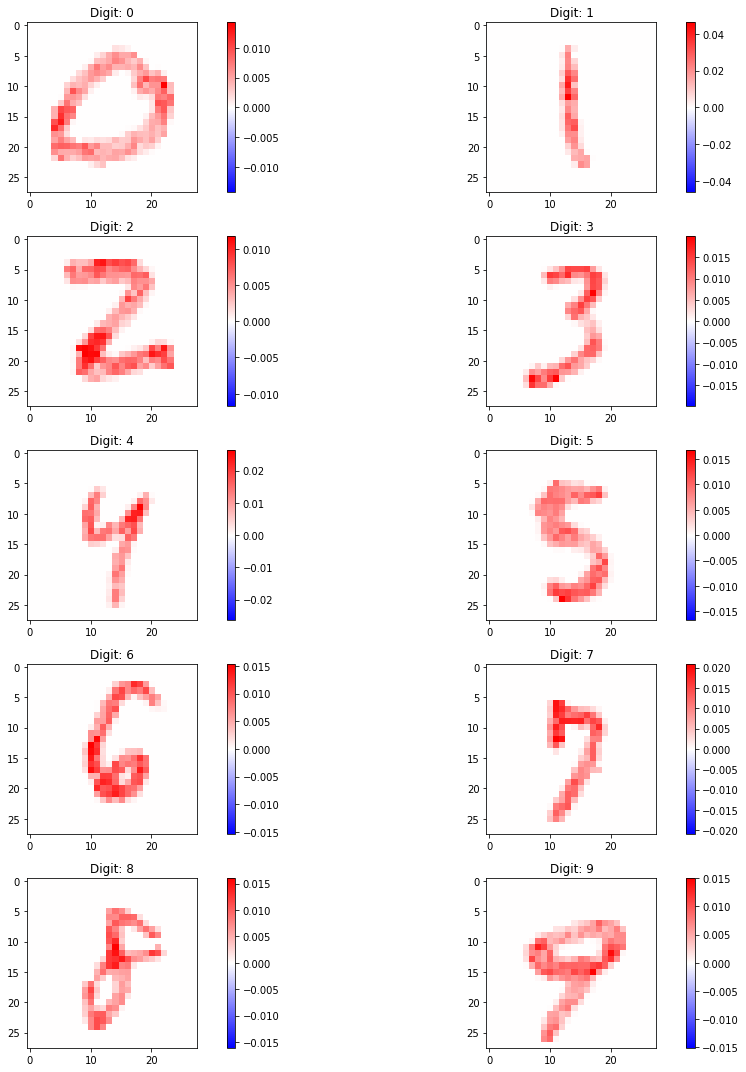

In [7]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    vmin, vmax = pixel_range(imgs10[2 * i])
    plt.imshow(np.reshape(imgs10[2 * i], [28, 28]), vmin=-vmax, vmax=vmax, cmap='bwr')
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    vmin, vmax = pixel_range(imgs10[2 * i + 1])
    plt.imshow(np.reshape(imgs10[2 * i + 1], [28, 28]), vmin=-vmax, vmax=vmax, cmap='bwr')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()

### 8. Displaying Images for LRP-$\alpha_2 \beta_1$

You can see that for LRP-$\alpha_2 \beta_1$, there are also spots with negative relevance scores.

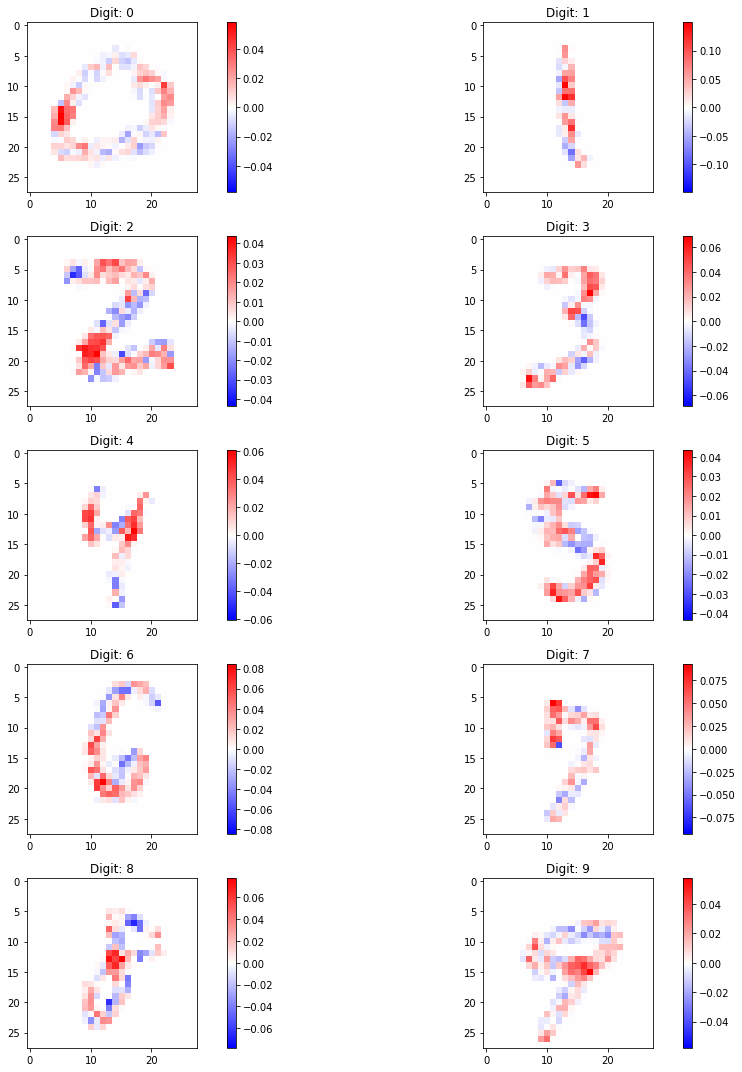

In [8]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    vmin, vmax = pixel_range(imgs21[2 * i])
    plt.imshow(np.reshape(imgs21[2 * i], [28, 28]), vmin=vmin, vmax=vmax, cmap='bwr')
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    vmin, vmax = pixel_range(imgs21[2 * i + 1])
    plt.imshow(np.reshape(imgs21[2 * i + 1], [28, 28]), vmin=vmin, vmax=vmax, cmap='bwr')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()